In [10]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<p style='font-size:18px'><b>1.1 Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> 1.2 Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> 1.3 Real World / Business Objectives and Constraints  </b></p>
1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data Overview </h2>
<p>
All of the data is in 2 files: Train and Test.
</p>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br>
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br>
<b>Size of Train.csv</b> - 6.75GB<br>
<b>Size of Test.csv</b> - 2GB<br>
<b>Number of rows in Train.csv</b> = 6034195<br>
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br>

**Data Field Explaination**

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>

In machine learning, multi-label classification is variant of the classification problem where multiple labels may be assigned to each instance. Multi-label classification is a generalization of multiclass classification, which is the single-label problem of categorizing instances into precisely one of more than two classes; in the multi-label problem there is no constraint on how many of the classes the instance can be assigned to.

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>


<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [2]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

<h3> 3.1.2 Counting the number of rows </h3>

In [11]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:01:58.364059


<h3>3.1.3 Checking for duplicates </h3>

In [4]:
# Obtaining dataset with the count of duplicates for each row
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags  LIMIT 100000;', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

# we can observe that there are duplicates
df_no_dup.head()

Time taken to run this cell : 0:11:38.266408


,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [10]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    62737
2    30569
3     6693
4        1
Name: cnt_dup, dtype: int64

In [11]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.127175


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [12]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    28861
2    25679
4    19712
1    13240
5    12508
Name: tag_count, dtype: int64

In [41]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [74]:
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train  LIMIT 100000""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:01.027963


<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [117]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [118]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 99999
Number of unique tags : 16321


In [119]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.each', '.emf', '.exe', '.htaccess', '.htpasswd']


<h3> 3.2.2 Number of times a tag appeared </h3>

In [120]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [121]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


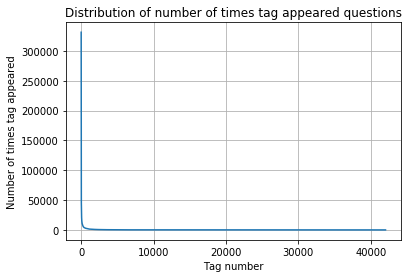

In [122]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

From the plot we could not make proper conclusions. Thus, considering the first 500 tags for better look.

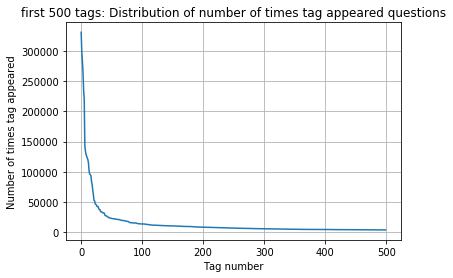

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22430  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [33]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

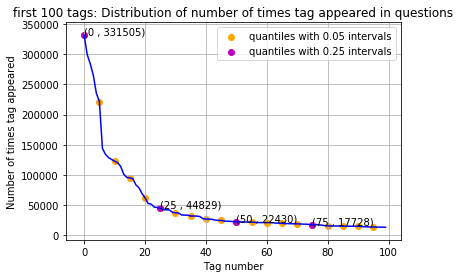

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22430  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [30]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared in questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [34]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


#### Observation:
Some tags occur much more frequenctly than others. There is much variations in the frequencies of the tags thus Micro-averaged F1-score is the appropriate metric for this probelm.

<h3>3.2.3 Most Frequent Tags </h3>

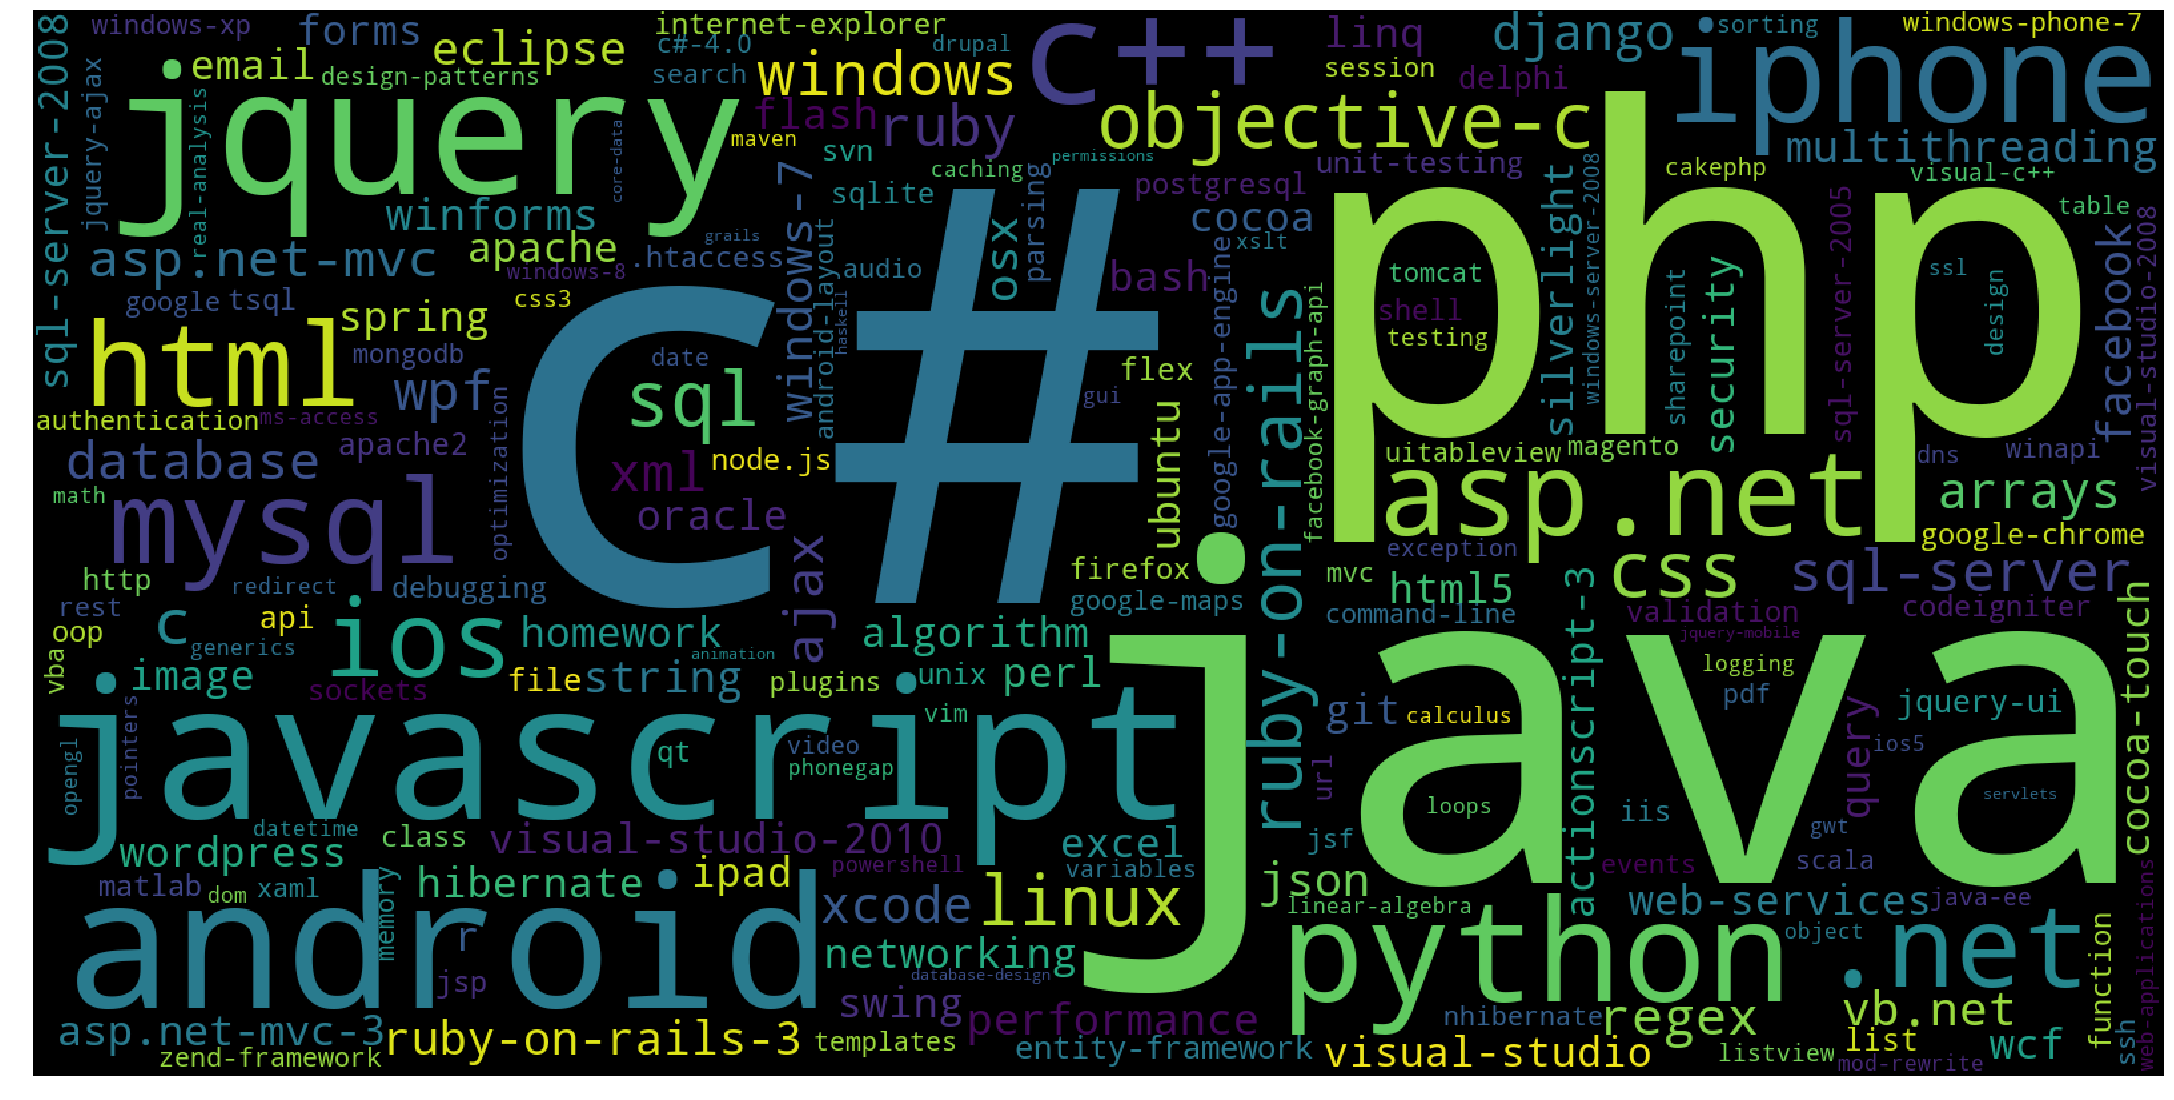

Time taken to run this cell : 0:00:09.106611


In [35]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

#### Observation:
From the above image it is clear that majority of the most frequent tags are programming language.

<h3> 3.2.4 Top 20 Tags</h3>

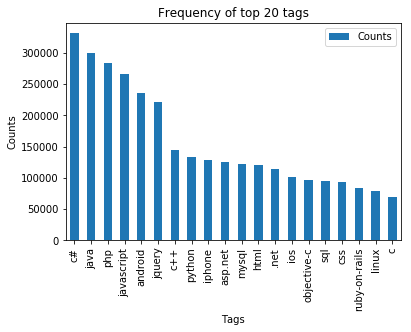

In [124]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.

<h2> 3.3 Analysis of Titles </h2>

In [106]:
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    title_data = pd.read_sql_query("""SELECT Title FROM no_dup_train LIMIT 100000;""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    title_data.drop(title_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    print(title_data.head())
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

                                               Title
1           Dynamic Datagrid Binding in Silverlight?
2           Dynamic Datagrid Binding in Silverlight?
3      java.lang.NoClassDefFoundError: javax/serv...
4      java.sql.SQLException:[Microsoft][ODBC Dri...
5       Better way to update feed on FB with PHP SDK
Time taken to run this cell : 0:00:01.798313


In [105]:
def text_prepare(text):
    ''' Function to create a list of lists of words in titles after removing stopwords'''
    text = re.sub(r'[^A-Za-z0-9#+.\-]+',' ',text)
    words = word_tokenize(str(text.lower()))
    
    #Removing all single letter and and stopwords from title except for the letter 'c'
    return [str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c')]

In [113]:
# preparing a list of lists of words in titles
title_data = [text_prepare(x) for x in title_data.iloc[:]['Title']]
title_data[0:2]

[['dynam', 'datagrid', 'bind', 'silverlight'],
 ['dynam', 'datagrid', 'bind', 'silverlight']]

<h3> 3.3.1 Similarity between Tags and Words in Titles </h3>

In [172]:
import gensim
# building w2v model on title data
w2v_model=gensim.models.Word2Vec(title_data,min_count=5,size=500, workers=4)

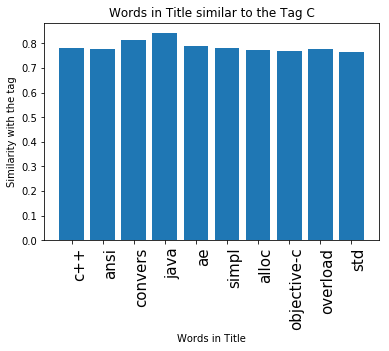

In [181]:
word = []
simi = []
for i,j in w2v_model.wv.most_similar('c'):
    word.append(i)
    simi.append(np.round(j,4))

fig, ax = plt.subplots()
ax.set_xticklabels(word, rotation = (90), fontsize = 15, va='top', ha='left')
plt.title("Words in Title similar to the Tag C")
plt.ylabel('Similarity with the tag')
plt.xlabel('Words in Title')
plt.bar(word, simi)
plt.show()

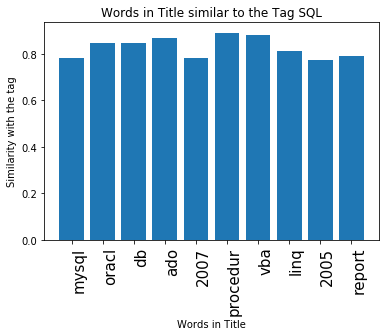

In [182]:
word = []
simi = []
for i,j in w2v_model.wv.most_similar('sql'):
    word.append(i)
    simi.append(np.round(j,4))

fig, ax = plt.subplots()
ax.set_xticklabels(word, rotation = (90), fontsize = 15, va='top', ha='left')
plt.title("Words in Title similar to the Tag SQL")
plt.ylabel('Similarity with the tag')
plt.xlabel('Words in Title')
plt.bar(word, simi)
plt.show()

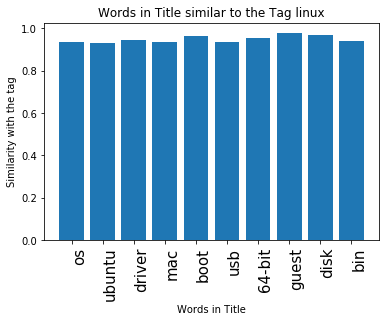

In [183]:
word = []
simi = []
for i,j in w2v_model.wv.most_similar('linux'):
    word.append(i)
    simi.append(np.round(j,4))

fig, ax = plt.subplots()
ax.set_xticklabels(word, rotation = (90), fontsize = 15, va='top', ha='left')
plt.title("Words in Title similar to the Tag linux")
plt.ylabel('Similarity with the tag')
plt.xlabel('Words in Title')
plt.bar(word, simi)
plt.show()

### Observation:
There is a large similarity between words in Title and the Tags predicted.

<h2>3.4 Preprocessing </h2>.
1. Sample 80K data points
2. Separate out code-snippets from Body
3. Remove Spcial characters from Question title and description (not in code)
4. Remove stop words (Except 'C')
5. Remove HTML Tags
6. Convert all the characters into small letters
7. Use SnowballStemmer to stem the words

In [55]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [60]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [4]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [70]:
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 60000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 80K rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 80001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [6]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1256
Avg. length of questions(Title+Body) after processing: 447
Percent of questions containing code: 56
Time taken to run this cell : 0:09:02.714444


In [7]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Saving Preprocessed data to a Database __

In [61]:
#Taking 80K entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [62]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [63]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 80000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [66]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [67]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [68]:
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]

# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 5770 out of  80000


In [71]:
# Spliting the dataset into train and test
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 60000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [40]:
print("Number of data points in train data :", y_train.shape[0])
print("Number of data points in test data :", y_test.shape[0])

Number of data points in train data : 60000
Number of data points in test data : 20000


## 4. Machine Learning Models 

### 4.1 Converting tags for multilabel problems 

In [72]:
start = datetime.now()
# converting data to BoW Vectorizer
count_vect = CountVectorizer(ngram_range=(3,4), max_features=10000)
x_train_multilabel = count_vect.fit_transform(x_train['question'])
x_test_multilabel = count_vect.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:58.960191


In [17]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (60000, 10000) Y : (60000, 500)
Dimensions of test data X: (20000, 10000) Y: (20000, 500)


## 4.2. Applying GridSearchCV for Logistic Regression with OneVsRest Classifier

#### Hyperparam tuning on lambda for Logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param = [{"estimator__C": [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
n_folds = 2
classifier_1 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
gsearch_cv = GridSearchCV(estimator=classifier_1, param_grid=param, cv=n_folds, scoring='f1_micro',verbose=1, n_jobs=-1)
gsearch_cv.fit(x_train_multilabel, y_train)

In [23]:
print("Best estimator for the model :\n ",gsearch_cv.best_estimator_)
print("Best Score for the model : ",gsearch_cv.best_score_)

Best estimator for the model :
  OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)
Best Score for the model :  0.104996277255


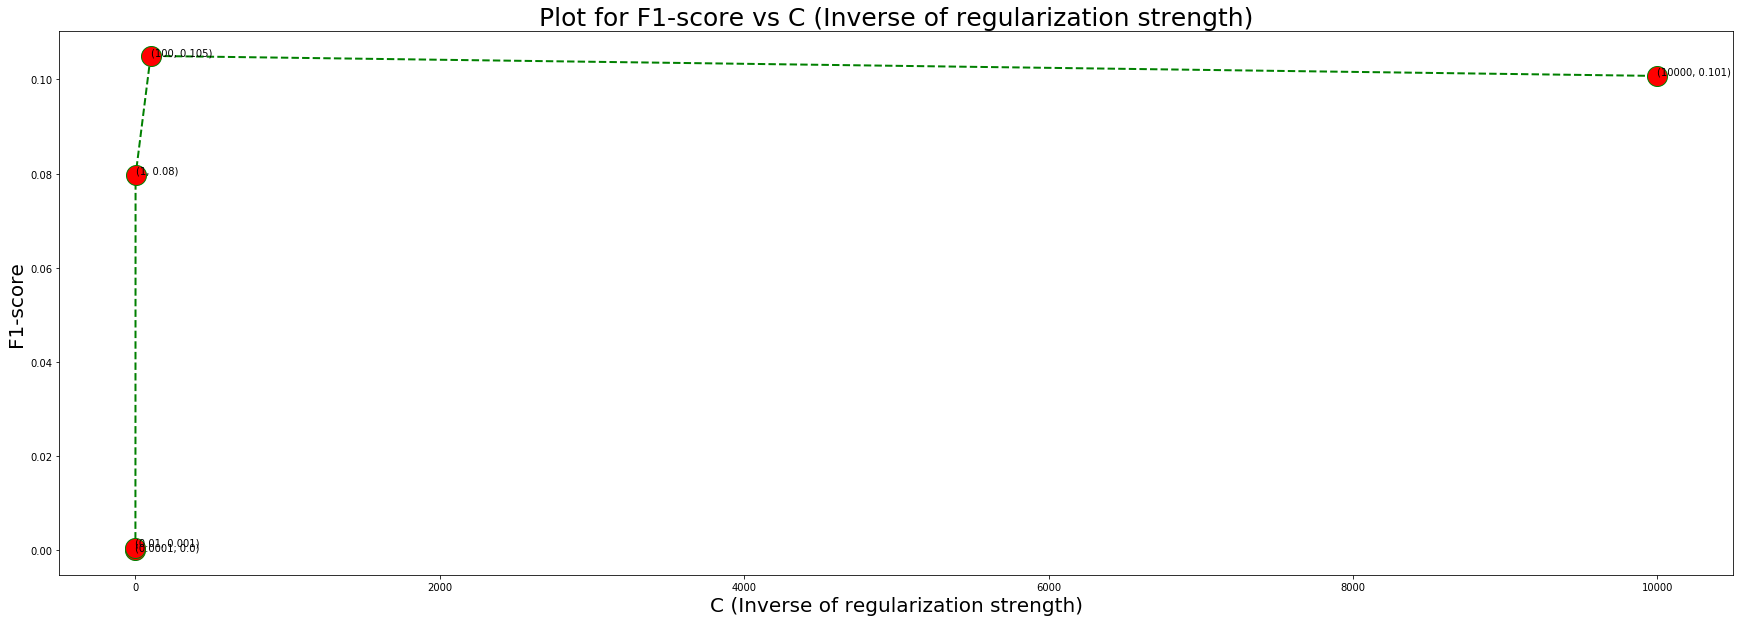

In [39]:
# Here we obtain the c values and their corresponding mean test scores.
cv_result = gsearch_cv.cv_results_         
mts = cv_result["mean_test_score"] #list that will hold the mean of cross validation scores for each c
c = cv_result["params"]

c_values = []               #list that will hold all the c values that the grid search cross validator tried.
for i in range(0,len(c)):
    c_values.append(c[i]["estimator__C"])

#Plot F1-score vs C values
plt.figure(figsize=(30,10))
plt.plot(c_values , mts, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=20)
for xy in zip(c_values, np.round(mts,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title('Plot for F1-score vs C (Inverse of regularization strength)',fontsize=25)
plt.xlabel('C (Inverse of regularization strength)',fontsize=20)
plt.ylabel('F1-score',fontsize=20)
plt.show()

In [24]:
classifier_1 = gsearch_cv.best_estimator_
classifier_1.fit(x_train_multilabel, y_train)

predictions_1 = classifier_1.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_1))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_1))


precision = precision_score(y_test, predictions_1, average='micro')
recall = recall_score(y_test, predictions_1, average='micro')
f1 = f1_score(y_test, predictions_1, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_1, average='macro')
recall = recall_score(y_test, predictions_1, average='macro')
f1 = f1_score(y_test, predictions_1, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_1))

Accuracy : 0.03475
Hamming loss  0.0078379
Micro-average quality numbers
Precision: 0.1953, Recall: 0.2140, F1-measure: 0.2042
Macro-average quality numbers
Precision: 0.0372, Recall: 0.0414, F1-measure: 0.0320
             precision    recall  f1-score   support

          0       0.71      0.41      0.52      9636
          1       0.19      0.14      0.16      3236
          2       0.06      0.10      0.07       848
          3       0.66      0.67      0.66      4323
          4       0.16      0.27      0.20       647
          5       0.07      0.11      0.09       164
          6       0.08      0.07      0.08       633
          7       0.05      0.04      0.04       145
          8       0.00      0.00      0.00         2
          9       0.15      0.32      0.21       520
         10       0.09      0.09      0.09       116
         11       0.59      0.04      0.07      1390
         12       0.30      0.38      0.34      1666
         13       0.06      0.06      0.06    

#### Observation:
1. Best Hyperparameter that is Optimal C = 100 for Logistic Regression with OneVsRest Classifier
2. Hamming Loss for Logistic Regression with OneVsRest Classifier is observed as 0.0078379
3. Micro-Averaged F1-measure is 0.2042 which is not a good score.

## 4.3 Applying OneVsRestClassifier with Linear-SVM (SGDClassifier with loss-hinge)

In [29]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.05425
Hamming loss  0.0052564
Micro-average quality numbers
Precision: 0.3909, Recall: 0.2121, F1-measure: 0.2750
Macro-average quality numbers
Precision: 0.0732, Recall: 0.0312, F1-measure: 0.0375
             precision    recall  f1-score   support

          0       0.81      0.42      0.55      9636
          1       0.20      0.13      0.16      3236
          2       0.06      0.10      0.07       848
          3       0.68      0.71      0.70      4323
          4       0.25      0.27      0.26       647
          5       0.14      0.15      0.15       164
          6       0.11      0.06      0.08       633
          7       0.13      0.05      0.07       145
          8       0.00      0.00      0.00         2
          9       0.25      0.35      0.29       520
         10       0.29      0.10      0.15       116
         11       0.92      0.05      0.09      1390
         12       0.45      0.34      0.39      1666
         13       0.14      0.05      0.07    

#### Observation:
1. Best Hyperparameter that is optimal alpha = 0.00001 for OneVsRestClassifier with Linear-SVM.
2. Hamming loss for OneVsRestClassifier with Linear-SVM is 0.0052564 which is less than Logistic Regression with OneVsRest Classifier .
3. Micro - Averaged F1-measure is 0.2750 which is more than Logistic Regression with OneVsRest Classifier. 
4. Thus, it is a better classifier model.

In [8]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = [ "Model","hyperparameter", "Accuracy","HammingLoss" , "MicroAvg F1-Score","MacroAvg F1-Score"]
table.add_row(["Logistic Regression OneVsRestClassifier","C = 100"," 0.03475","0.0078379","0.2042","0.0320"])
table.add_row(["Linear-SVM OneVsRestClassifier","alpha = 0.00001", "0.05425" , "0.0052564", "0.2750","0.0375"])
print(table)

+-----------------------------------------+-----------------+----------+-------------+-------------------+-------------------+
|                  Model                  |  hyperparameter | Accuracy | HammingLoss | MicroAvg F1-Score | MacroAvg F1-Score |
+-----------------------------------------+-----------------+----------+-------------+-------------------+-------------------+
| Logistic Regression OneVsRestClassifier |     C = 100     |  0.03475 |  0.0078379  |       0.2042      |       0.0320      |
|      Linear-SVM OneVsRestClassifier     | alpha = 0.00001 | 0.05425  |  0.0052564  |       0.2750      |       0.0375      |
+-----------------------------------------+-----------------+----------+-------------+-------------------+-------------------+


<h1> Step by step procedure:</h1>

<h2> <font color='blue'>1.  Business Problem: </font></h2>
It covers the basic details which should be known before solving the case study.<br>
<p>
**1.1. Description:** describes the background details of the StackOverFlow website which is must to know to get the insights.<br>
**1.2. Problem Statemtent:** describes the problem which we are intended to solve.<br>
**1.3. Real World / Business Objectives and Constraints:** describes the objectives which we have to keep in mind while solving the problem. We need to give proper attention towards the constraints stated under this.
</p>

<h2> <font color='blue'>2. Machine Learning problem:</font></h2>
Looking into the problem as a Machine learning problem.
<p>
**2.1 Data Overview:** Understanding the data and the data fields.<br>
**2.2 Mapping the real-world problem to a Machine Learning Problem:** <br>
_2.2.1 Type of Machine Learning Problem:_ Understand the type of problem i.e. classification (binary classification, Multi-class classification, Multi-label classification), regression, etc<br>
_2.2.2 Performance Metric:_ Percieve the appropriate metric for this problem.
</p>


<h2> <font color='blue'>3. Exploratory Data Analysis:</font></h2>
<p>
**3.1 Data Loading and Cleaning **<br>
*3.1.1 Using Pandas with SQLite to Load the data:* As the size of dataset is too large thus using SQLite for faster implementation.<br>
*3.1.2 Counting the number of rows:* understanding data better<br>
*3.1.3 Checking for duplicates:* removing any duplicates if present<br>
</p>
<p>
**3.2 Analysis of Tags **<br>
*3.2.1 Total number of unique tags: * getting number of unique tags to use them as class labels.<br>
*3.2.2 Number of times a tag appeared:* get the frequencies for each tag<br>
*3.2.3 Most frequent tag:* keep the most frequent tag and ignore the others for better model.<br>
*3.2.4 Top 20 Tags:* to show the top 20 tags in the corpus
</p>
<p>
**3.3 Analysis of Titles**<br>
*3.3.1 Similarity between the words in Title and the Tags*
</p>
<p>
**3.4 Preprocessing** <br>
<ol>
<li> Sample 80K data points</li>
<li> Separate out code-snippets from Body </li>
<li> Remove Special characters from Question title and description (not in code)</li>
<li> Remove stop words (Except 'C')</li>
<li> Remove HTML Tags</li>
<li> Convert all the characters into small letters</li>
<li> Use SnowballStemmer to stem the words</li>
</ol>
</p>

<h2> <font color='blue'> 4. Machine Learning Models</font></h2>
<br>
**4.1 Converting tags for multilabel problems:** Each tag is to be converted to a label. This allows us to apply Multi-Label Classification problem<br>
**4.2. Applying GridSearchCV for Logistic Regression with OneVsRestClassifier**<br>
**4.3 Applying OneVsRestClassifier with Linear-SVM (SGDClassifier with loss-hinge)**<br>
<p> As we are dealing with high dimension data and using OneVsRestClassifier thus Linear models work best.<br> Therefore, using Logistic regression and Linear-SVM</p>